# SIR model - Split Approach

Solving the SIR model with constant transmission rate $\beta$ and recovery rate $\delta$.

$$
\begin{cases}
\frac{dS}{dt} &= -\frac{\beta}{N} I S, \\
\frac{dI}{dt} &= \frac{\beta}{N} I S - \delta I, \\
\frac{dR}{dt} &= \delta I,
\end{cases}
$$

where $t \in [0, 90]$ and with the initial conditions $S(0) = N - 1$, $I(0) = 1$, and $R(0) = 0$.

## Environment Setup

Importing libraries with first loading .env file, which specifies which backend DeepXDE should use

In [65]:
from dotenv import load_dotenv

load_dotenv()

import re
import torch
import deepxde as dde
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.model_selection import train_test_split

if torch.backends.mps.is_available():
  torch.set_default_device("mps")

Apply some configurations to the plots.

In [66]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif')

sns.set_theme(style="darkgrid")

Set random seed for reproducibility

In [67]:
seed = 1303

np.random.seed(seed)
torch.manual_seed(seed)
dde.config.set_random_seed(seed)

Define the output directories for saving the plots and data.

In [68]:
data_dir = "data"
assets_dir = "assets"

## Synthetic data generation

Building a SIR model to generate a discrete synthetic dataset in a closed time interval.

This dataset will be used as a starting point for creating both the true solution used during the l2 regularization term and observed data used during the training of the network.

### System configuration

The following parameters are used (using Italy as reference):

In [69]:
N = 56e6  # total population
delta = 1 / 5  # recovery rate (1 / mean infectious period)
r0 = 3.0  # basic reproduction number
real_beta = delta * r0  # transmission rate

The following time interval is used:

In [70]:
T0, TF = 0, 90  # (days)

### System definition

Define the SIR model and the initial conditions.

In [71]:
def SIR(x, t, delta, beta, N):
  S, I, R = x
  _lambda = beta * I / N
  dSdt = -_lambda * S
  dIdt = _lambda * S - delta * I
  dRdt = delta * I
  return [dSdt, dIdt, dRdt]


S0 = N - 1
I0 = 1
R0 = 0

Define a function to generate a discrete solution for the SIR model based on a time interval.

In [72]:
def solve_sir(t):
  x = odeint(SIR, [S0, I0, R0], t, args=(delta, real_beta, N))
  S = x[:, 0]
  I = x[:, 1]
  R = x[:, 2]
  return S, I, R

### Data generation

Generate a synthetic dataset and a synthetic observation of $I(t)$ by adding some noise to the true solution.

In [73]:
t_data = np.linspace(T0, TF, TF - T0 + 1)
S_data, I_data, R_data = solve_sir(t_data)

I_obs = np.random.poisson(I_data)

Plot the synthetic dataset and the observed $I(t)$.

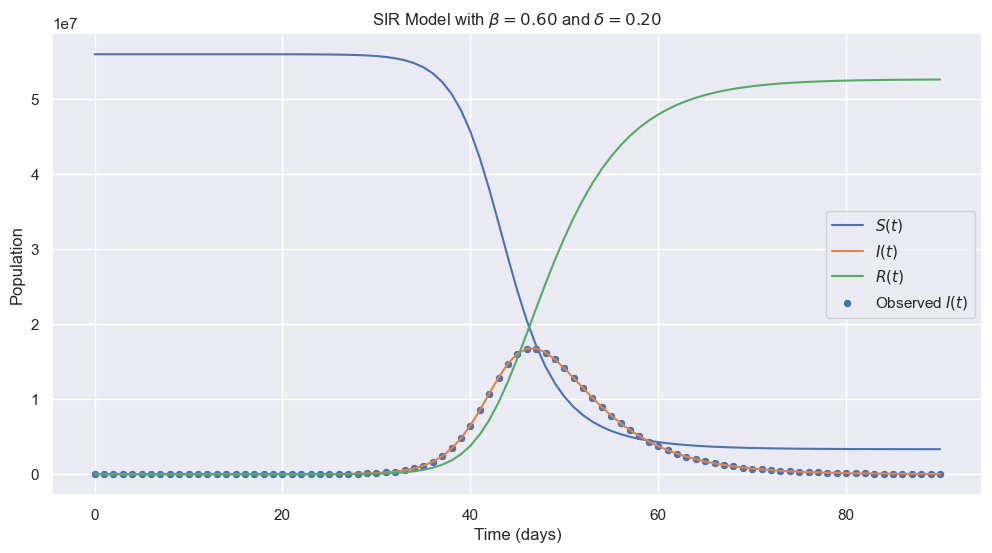

In [74]:
plt.subplots(figsize=(12, 6))

sns.lineplot(x=t_data, y=S_data, label=r"$S(t)$")
sns.lineplot(x=t_data, y=I_data, label=r"$I(t)$")
sns.lineplot(x=t_data, y=R_data, label=r"$R(t)$")
sns.scatterplot(x=t_data, y=I_obs, label=r"Observed $I(t)$")

plt.title(
  f"SIR Model with $\\beta = {real_beta:.2f}$ and $\\delta = {delta:.2f}$"
)
plt.xlabel(r"Time (days)")
plt.ylabel(r"Population")

plt.savefig(f"{assets_dir}/synthetic_data.png")

## Data Scaling

Scale both dataset and observation by a constant $C$ and into a time interval $[0, 1]$.

This is necessary to avoid numerical instability during the training of the network.

Define the scaling and unscaling functions.

In [75]:
C = 1e5


def scale_time(t):
  return t / TF


def unscale_time(t):
  return t * TF


def scale_population(x):
  return x / C


def unscale_population(x):
  return x * C

From now on, we will only use the scaled data.

In [76]:
t_data = scale_time(t_data.reshape(-1, 1))

I_obs = scale_population(I_obs.reshape(-1, 1))

## Modelling a Split Approach

Define two networks to solve the SIR model. The first is responsible only for the regression on the observed data, and the second is responsible to incorporate the ODE system and the initial conditions.

### Networks configuration

The following hyperparameters are used for both networks:

In [77]:
first_layer_size = [1] + [50] * 3 + [1]
second_layer_size = [1] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"

first_optimizer = "adam"
second_optimizer = "L-BFGS"
lr = 0.001
loss_function = "MSE"

batch_size = 1000
first_iterations = 50000
second_iterations = 30000

## First Stage: Data Regression

Apply a test-train split to the synthetic dataset.

In [78]:
t_train, t_test, I_train, I_test = train_test_split(
  t_data,
  I_obs,
  test_size=0.2,
  random_state=seed,
  shuffle=True
)

### Model definition

Define the dataset fitting problem.

In [79]:
data = dde.data.DataSet(
  t_train,
  I_train,
  t_test,
  I_test
)

Define the network.

In [80]:
class PositiveOutputNN(dde.nn.pytorch.FNN):
  def forward(self, x):
    y = super().forward(x)
    return torch.log1p(torch.exp(y))  # Softplus


net_I = PositiveOutputNN(first_layer_size, activation, initializer)

Finally, define the model.

In [81]:
model = dde.Model(data, net_I)

### Model training

A two-stage training is used to train the model. First, we train using the `adam` optimizer and the loss function. Then, we switch to the `L-BFGS` optimizer to faster converge.

Compile and train the model using `adam`.
At this state, we include the beta parameter as an external trainable variable.

In [82]:
model.compile(
  optimizer=first_optimizer,
  lr=lr,
  loss=loss_function
)

loss_history, train_state = model.train(
  batch_size=batch_size,
  iterations=first_iterations
)

Compiling model...
'compile' took 0.000098 s

Training model...

Step      Train loss    Test loss     Test metric
0         [3.82e+03]    [5.72e+02]    []  
1000      [2.11e+03]    [7.01e+02]    []  
2000      [2.08e+03]    [9.28e+02]    []  
3000      [2.08e+03]    [9.36e+02]    []  
4000      [2.08e+03]    [9.36e+02]    []  
5000      [2.08e+03]    [9.36e+02]    []  
6000      [2.08e+03]    [9.36e+02]    []  
7000      [2.08e+03]    [9.36e+02]    []  
8000      [2.08e+03]    [9.36e+02]    []  
9000      [2.08e+03]    [9.36e+02]    []  
10000     [2.08e+03]    [9.36e+02]    []  
11000     [2.08e+03]    [9.36e+02]    []  
12000     [2.08e+03]    [9.36e+02]    []  
13000     [2.08e+03]    [9.37e+02]    []  
14000     [2.08e+03]    [9.37e+02]    []  
15000     [2.08e+03]    [9.37e+02]    []  
16000     [2.08e+03]    [9.37e+02]    []  
17000     [2.08e+03]    [9.37e+02]    []  
18000     [2.08e+03]    [9.37e+02]    []  
19000     [2.08e+03]    [9.37e+02]    []  
20000     [2.08e+03]    [

Fine-tune the model using `L-BFGS` optimizer.

In [83]:
model.compile(
  optimizer=second_optimizer,
  loss=loss_function
)

_, _ = model.train(
  batch_size=batch_size,
  iterations=first_iterations
)

Compiling model...
'compile' took 0.001125 s

Training model...

Step      Train loss    Test loss     Test metric
50000     [2.08e+03]    [9.37e+02]    []  

Best model at step 30000:
  train loss: 2.08e+03
  test loss: 9.37e+02
  test metric: []

'train' took 0.082322 s



## First Stage Evaluation

Save the loss history and the model state into .dat files.

In [84]:
dde.saveplot(
  loss_history,
  train_state,
  issave=True,
  isplot=False,
  output_dir=f"{data_dir}/first"
)

Saving loss history to data/first/loss.dat ...
Saving training data to data/first/train.dat ...
Saving test data to data/first/test.dat ...


### Plotting the results

Plot the loss history during training.

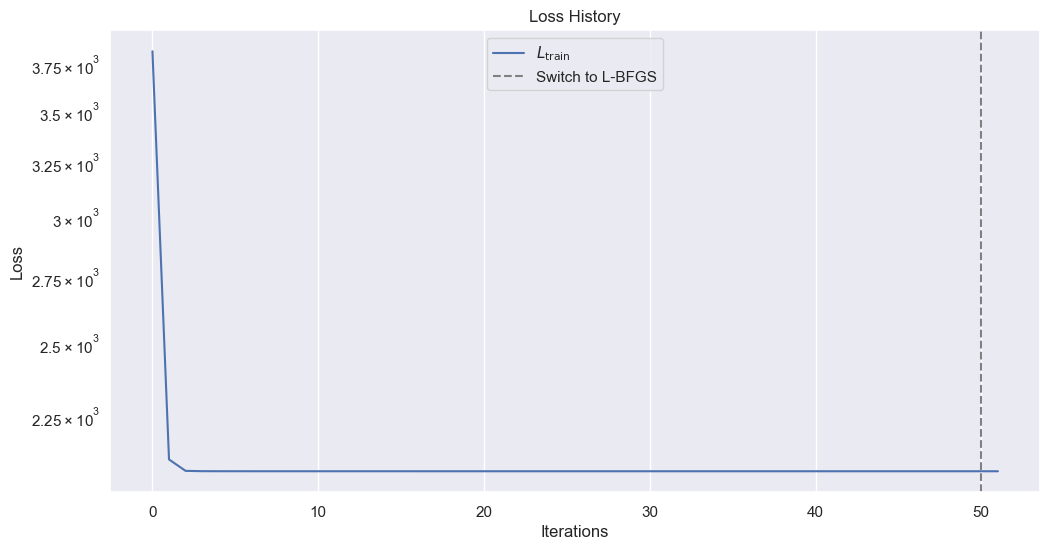

In [85]:
columns = ["$L_{\mathrm{train}}$"]
losses = pd.DataFrame(loss_history.loss_train, columns=columns)

plt.subplots(figsize=(12, 6))

for column in columns:
  sns.lineplot(data=losses[column], label=column)

plt.axvline(
  first_iterations / batch_size,
  color="gray",
  linestyle="--",
  label="Switch to L-BFGS",
)
plt.yscale("log")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss History")
plt.legend()
plt.savefig(f"{assets_dir}/first_loss_history.png")
plt.show()

### Predictions

Generate true solution to test the model.

Predict the solution using the trained model and unscale the results.

In [86]:
t_test = np.linspace(T0, TF, 100)
S_true, I_true, R_true = solve_sir(t_test)

I_pred = model.predict(scale_time(t_test).reshape(-1, 1)).reshape(-1)
I_pred = unscale_population(I_pred)

Plot the true solution and the predicted solution.

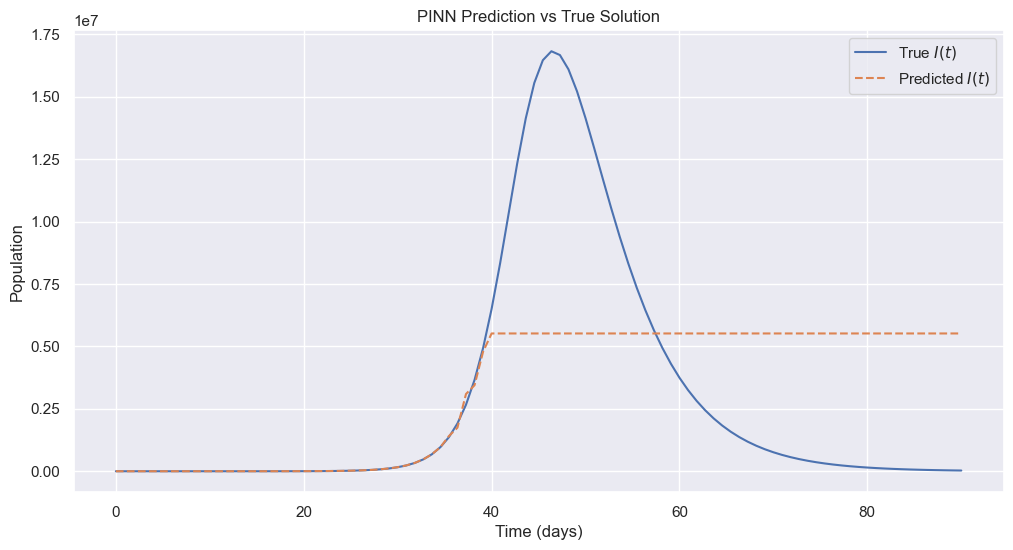

In [87]:
plt.subplots(figsize=(12, 6))

sns.lineplot(x=t_test, y=I_true, label="True $I(t)$")
sns.lineplot(x=t_test, y=I_pred, label="Predicted $I(t)$", linestyle="--")

plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.title("PINN Prediction vs True Solution")
plt.legend()
plt.savefig(f"{assets_dir}/first_predictions.png")
plt.show()

### Accuracy

Calculate the Mean Squared Error between the true solution and the predicted solution.

In [88]:
mse_I = np.mean((I_true - I_pred) ** 2)

MSEs = pd.DataFrame(
  {
    "Component": ["Infected"],
    "MSE":       [mse_I]
  },
)

MSEs["MSE"] = MSEs["MSE"].map("{:.2e}".format)

from IPython.display import display, HTML

display(HTML(MSEs.to_html(index=False)))

Component,MSE
Infected,1.84e+13


## Second Stage: ODE System

Freeze the first network to use it as a fixed function.

In [89]:
net_I = net_I.train(False)

### Model definition

Define the time domain geometry, scaled to the range [0, 1].

In [90]:
geom = dde.geometry.TimeDomain(scale_time(T0), scale_time(TF))

Define the beta parameter as a trainable variable with initial guess.

In [91]:
beta = dde.Variable(0.5)

Define the ODE system, adjusted to use the scaled data.

In [92]:
C1 = (TF - T0) * C / N
C2 = (TF - T0) * delta


def ode_system(t, y):
  S = y[:, 0:1]
  _ = y[:, 1:2]
  dS_t = dde.grad.jacobian(y, t, i=0)
  dR_t = dde.grad.jacobian(y, t, i=1)

  I = net_I(t)

  res_s = dS_t - (- C1 * beta * I * S)
  res_r = dR_t - (C2 * I)
  return torch.cat([res_s, res_r], dim=1)

Define the initial condition.

In [93]:
def boundary(_, on_initial):
  return on_initial


ic_S = dde.icbc.IC(geom, lambda t: scale_population(S0), boundary, component=0)
ic_I = dde.icbc.IC(geom, lambda t: scale_population(I0), boundary, component=1)
ic_R = dde.icbc.IC(geom, lambda t: scale_population(R0), boundary, component=2)

Define the ODE problem with the ICs.

We use 90 points inside the domain and 2 points on the boundary (the start and the end of the time domain).

We use the synthetic (and scaled) time domain to define the points where the data is observed.

In [94]:
data = dde.data.PDE(
  geom,
  ode_system,
  [ic_S, ic_R],
  num_boundary=2,
  anchors=t_data,
  # num_test=20,
)

Define the network.

In [95]:
net = dde.nn.pytorch.FNN(second_layer_size, activation, initializer)

Finally, define the model.

In [96]:
model = dde.Model(data, net)

### Model training

A two-stage training is used to train the model. First, we train using the `adam` optimizer and the loss function. Then, we switch to the `L-BFGS` optimizer to faster converge.

Compile and train the model using `adam`.
At this state, we include the beta parameter as an external trainable variable.

In [97]:
variable = dde.callbacks.VariableValue(
  beta,
  period=batch_size,
  filename=f"{data_dir}/beta_var.dat",
)

model.compile(
  optimizer=first_optimizer,
  lr=lr,
  loss=loss_function,
  external_trainable_variables=[beta],
)

loss_history, train_state = model.train(
  batch_size=batch_size,
  iterations=second_iterations,
  callbacks=[variable]
)

Compiling model...
'compile' took 0.000197 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.83e+05, 3.14e+05, -5.60e+02]   [2.83e+05, 3.14e+05, -5.60e+02]   []  
1000      [1.97e+05, 2.50e+05, -5.00e+02]   [1.97e+05, 2.50e+05, -5.00e+02]   []  
2000      [1.55e+05, 2.12e+05, -4.61e+02]   [1.55e+05, 2.12e+05, -4.61e+02]   []  
3000      [1.08e+05, 1.87e+05, -4.33e+02]   [1.08e+05, 1.87e+05, -4.33e+02]   []  
4000      [1.12e+05, 1.79e+05, -4.23e+02]   [1.12e+05, 1.79e+05, -4.23e+02]   []  
5000      [9.73e+04, 1.63e+05, -4.03e+02]   [9.73e+04, 1.63e+05, -4.03e+02]   []  
6000      [7.38e+04, 1.44e+05, -3.80e+02]   [7.38e+04, 1.44e+05, -3.80e+02]   []  
7000      [6.54e+04, 1.27e+05, -3.57e+02]   [6.54e+04, 1.27e+05, -3.57e+02]   []  
8000      [4.65e+04, 1.09e+05, -3.30e+02]   [4.65e+04, 1.09e+05, -3.30e+02]   []  
9000      [3.81e+04, 9.60e+04, -3.10e+02]   [3.81e+04, 9.60e+04, -3.10e+02]   []  
10000     [2.77

Fine-tune the model using `L-BFGS` optimizer.

In [98]:
model.compile(
  optimizer=second_optimizer,
  loss=loss_function
)

_, _ = model.train(
  batch_size=batch_size,
  iterations=first_iterations
)

Compiling model...
'compile' took 0.000703 s

Training model...

Step      Train loss                        Test loss                         Test metric
30000     [1.98e+01, 3.09e-04, -1.76e-02]   [1.98e+01, 3.09e-04, -1.76e-02]   []  
30030     [1.94e+01, 1.75e-03, -4.18e-02]   [1.94e+01, 1.75e-03, -4.18e-02]   []  
30050     [1.93e+01, 3.38e-03, -5.82e-02]   [1.93e+01, 3.38e-03, -5.82e-02]   []  
30058     [1.91e+01, 4.74e-03, -6.88e-02]   [1.91e+01, 4.74e-03, -6.88e-02]   []  
30150     [1.74e+01, 4.27e-05, -6.53e-03]   [1.74e+01, 4.27e-05, -6.53e-03]   []  

Best model at step 30150:
  train loss: 1.74e+01
  test loss: 1.74e+01
  test metric: []

'train' took 7.407589 s



## Evaluation

Save the loss history and the model state into .dat files.

In [99]:
dde.saveplot(
  loss_history,
  train_state,
  issave=True,
  isplot=False,
  output_dir=f"{data_dir}/second"
)

Saving loss history to data/second/loss.dat ...
Saving training data to data/second/train.dat ...
Saving test data to data/second/test.dat ...


Plot the loss history during training.

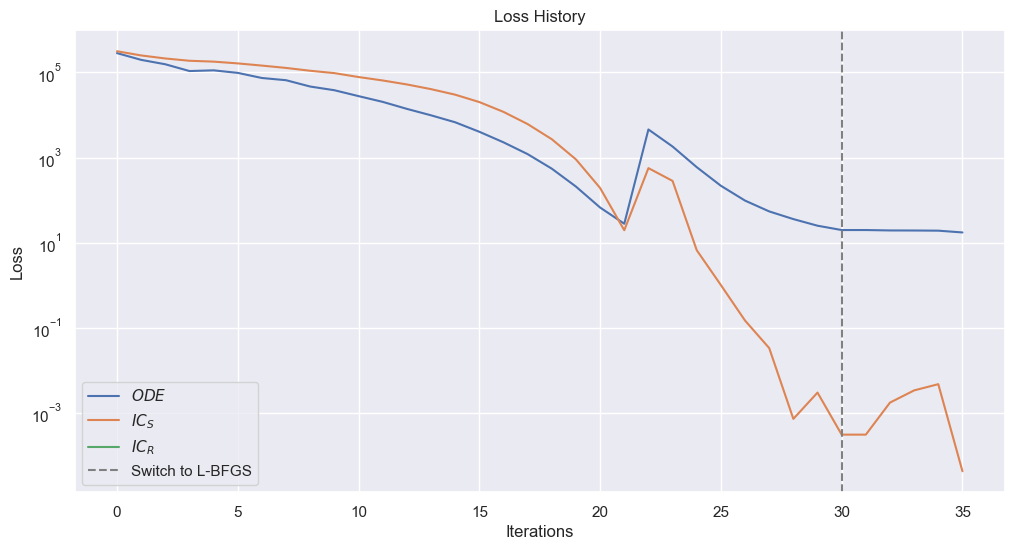

In [100]:
columns = ["$ODE$", "$IC_S$", "$IC_R$"]
losses = pd.DataFrame(loss_history.loss_train, columns=columns)

plt.subplots(figsize=(12, 6))

for column in columns:
  sns.lineplot(data=losses[column], label=column)

plt.axvline(
  second_iterations / batch_size,
  color="gray",
  linestyle="--",
  label="Switch to L-BFGS",
)
plt.yscale("log")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss History")
plt.legend()
plt.savefig(f"{assets_dir}/second_loss_history.png")
plt.show()

Plot the beta parameter during training.

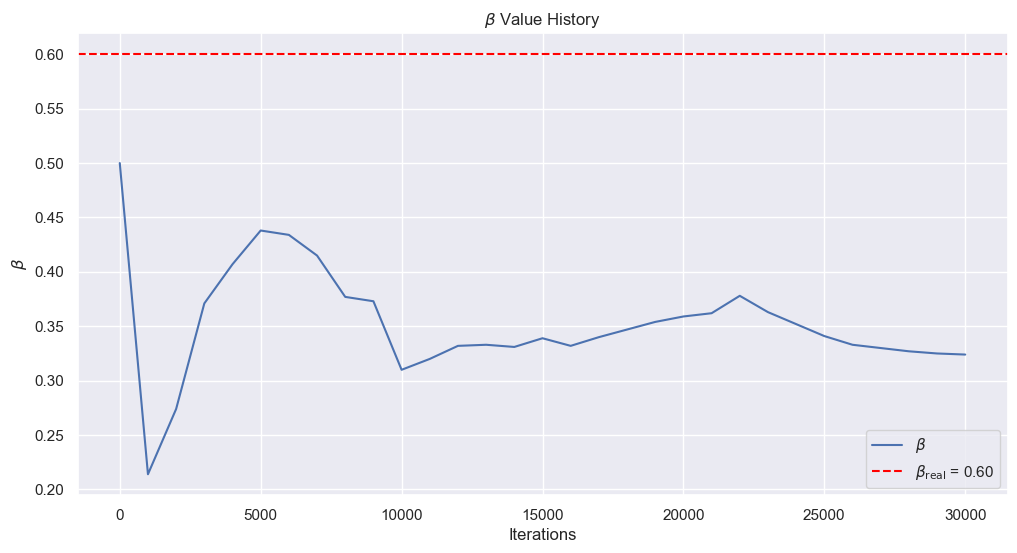

In [101]:
beta_x = []
beta_y = []

pattern = re.compile(r'(\d+)\s+\[([0-9.eE+-]+)\]')

with open(f"{data_dir}/beta_var.dat", "r") as f:
  for line in f:
    match = pattern.match(line)
    if match:
      iteration = int(match.group(1))
      beta = float(match.group(2))
      beta_x.append(iteration)
      beta_y.append(beta)

beta_values = pd.DataFrame(beta_y, index=beta_x, columns=["$\\beta$"])

plt.subplots(figsize=(12, 6))

sns.lineplot(data=beta_values)
plt.axhline(
  real_beta,
  color="red",
  linestyle="--",
  label=r"$\beta_{\mathrm{real}}$" + f" = {real_beta:.2f}",
)
plt.xlabel("Iterations")
plt.ylabel(r"$\beta$")
plt.legend()
plt.title(r"$\beta$ Value History")
plt.savefig(f"{assets_dir}/beta_history.png")
plt.show()

### Predictions

Predict the solution using the trained model and unscale the results (the true solution was already computed in the first stage).

In [102]:
y_pred = model.predict(scale_time(t_test).reshape(-1, 1))
S_pred, R_pred = y_pred[:, 0], y_pred[:, 1]

S_pred = unscale_population(S_pred)
R_pred = unscale_population(R_pred)

Plot the true solution and the predicted solution.

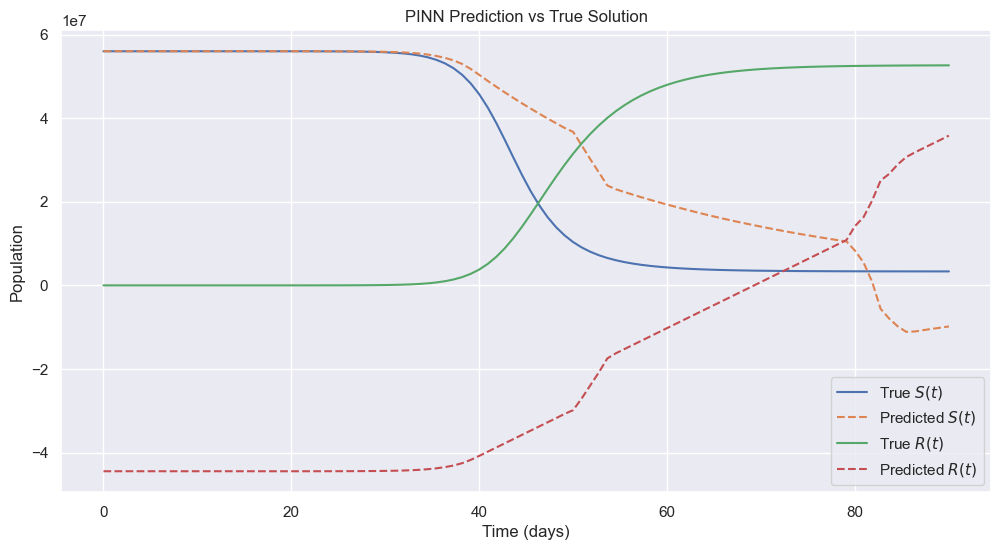

In [103]:
plt.subplots(figsize=(12, 6))

sns.lineplot(x=t_test, y=S_true, label="True $S(t)$")
sns.lineplot(x=t_test, y=S_pred, label="Predicted $S(t)$", linestyle="--")
sns.lineplot(x=t_test, y=R_true, label="True $R(t)$")
sns.lineplot(x=t_test, y=R_pred, label="Predicted $R(t)$", linestyle="--")

plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.title("PINN Prediction vs True Solution")
plt.legend()
plt.savefig(f"{assets_dir}/second_predictions.png")
plt.show()

### Accuracy

Calculate the Mean Squared Error between the true solution and the predicted solution.

In [104]:
mse_S = np.mean((S_true - S_pred) ** 2)
mse_R = np.mean((R_true - R_pred) ** 2)

MSEs = pd.DataFrame(
  {
    "Component": ["Susceptible", "Recovered"],
    "MSE":       [mse_S, mse_R]
  },
)

MSEs["MSE"] = MSEs["MSE"].map("{:.2e}".format)

display(HTML(MSEs.to_html(index=False)))

Component,MSE
Susceptible,1.19e+14
Recovered,2.20e+15


## Conclusion
